In [16]:
import xarray as xr
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [17]:
dataset = xr.open_dataset(r"C:\US-Baltimore_clean_observations_v1.nc", engine='netcdf4') 
data = dataset.sel(time=slice('2003-01-01', '2006-12-31'))
print(f"Временной диапазон: {data.time.min().values} → {data.time.max().values}")
print(f"Размер: {data.dims['time']} записей")
print(f"Всего переменных: {len(data.data_vars)}")

Временной диапазон: 2003-01-01T00:00:00.000000000 → 2006-12-31T23:00:00.000000000
Размер: 35064 записей
Всего переменных: 30


In [18]:
targets = ['Qh', 'Qle', 'Qtau']
all_vars = list(data.data_vars)
predictors = [v for v in all_vars if '_qc' not in v and v not in targets]
df = data[predictors + targets].to_dataframe().reset_index()

df['Wind_speed'] = np.sqrt(df['Wind_N']**2 + df['Wind_E']**2)

df['Net_Radiation'] = (df['SWdown'] - df['SWup']) + (df['LWdown'] - df['LWup'])

df['es'] = 6.112 * np.exp((17.67 * df['Tair']) / (df['Tair'] + 243.5))  # насыщенное, hPa
df['ea'] = df['Qair'] * df['PSurf'] / (0.622 + 0.378 * df['Qair'])       # актуальное
df['VPD'] = df['es'] - df['ea']
df['VPD'] = df['VPD'].clip(lower=0)

predictors = [
    'SWdown', 'LWdown', 'Tair', 'Qair', 
    'SoilTemp', 'Wind_speed', 'Net_Radiation', 'VPD'
]

# Очистка от NaN в предикторах и целях
df_clean = df[predictors + targets].dropna()

print(f"\nПосле добавления фич и очистки осталось строк: {len(df_clean)}")
print(f"Финальные цели: {targets}")
print(f"Финальные предикторы ({len(predictors)}): {predictors}")


После добавления фич и очистки осталось строк: 7956
Финальные цели: ['Qh', 'Qle', 'Qtau']
Финальные предикторы (8): ['SWdown', 'LWdown', 'Tair', 'Qair', 'SoilTemp', 'Wind_speed', 'Net_Radiation', 'VPD']


In [19]:
models_lr = {}
models_ridge = {}
results_lr = {}
results_ridge = {}

# Простой набор предикторов (без engineered features) — для LinearRegression
simple_predictors = ['SWdown', 'LWdown', 'Tair', 'Qair', 'SoilTemp']

# Полный улучшенный набор (с Wind_speed, Net_Radiation, VPD) — для Ridge
full_predictors = predictors  # это ваш список из предыдущего кода: 
# ['SWdown', 'LWdown', 'Tair', 'Qair', 'SoilTemp', 'Wind_speed', 'Net_Radiation', 'VPD']

for target in targets:
    print(f"\n\n{'='*70}")
    print(f"ОБУЧЕНИЕ ДЛЯ {target.upper()}")
    print(f"{'='*70}")
    
    # Берем только строки, где есть значение целевой переменной
    df_train = df_clean.dropna(subset=[target])
    
    if len(df_train) < 100:
        print(f"Недостаточно данных для {target} ({len(df_train)} строк)")
        continue
    
    y = df_train[target]
    
    # === 1. LinearRegression на простом наборе ===
    X_simple = df_train[simple_predictors]
    
    X_train_s, X_test_s, y_train, y_test = train_test_split(
        X_simple, y, test_size=0.2, random_state=42, shuffle=False  # shuffle=False — важно для временных рядов!
    )
    
    model_lr = LinearRegression()
    model_lr.fit(X_train_s, y_train)
    models_lr[target] = model_lr
    
    y_pred_lr = model_lr.predict(X_test_s)
    
    results_lr[target] = {
        'R2': r2_score(y_test, y_pred_lr),
        'MSE': mean_squared_error(y_test, y_pred_lr)
    }
    
    # === 2. Ridge на полном улучшенном наборе ===
    X_full = df_train[full_predictors]
    
    X_train_f, X_test_f, _, _ = train_test_split(
        X_full, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    model_ridge = Ridge(alpha=1.0)  # можно подобрать alpha позже
    model_ridge.fit(X_train_f, y_train)
    models_ridge[target] = model_ridge
    
    y_pred_ridge = model_ridge.predict(X_test_f)
    
    results_ridge[target] = {
        'R2': r2_score(y_test, y_pred_ridge),
        'MSE': mean_squared_error(y_test, y_pred_ridge)
    }
    
    # === Вывод результатов ===
    print(f"LinearRegression (простые фичи: {simple_predictors})")
    print(f"    → R²:  {results_lr[target]['R2']:.4f} | MSE: {results_lr[target]['MSE']:.4f}")
    
    print(f"Ridge (улучшенные фичи: {len(full_predictors)} фич, включая Net_Radiation, VPD, Wind_speed)")
    print(f"    → R²:  {results_ridge[target]['R2']:.4f} | MSE: {results_ridge[target]['MSE']:.4f}")
    
    improvement = results_ridge[target]['R2'] - results_lr[target]['R2']
    print(f"    Улучшение R²: {improvement:+.4f}")



ОБУЧЕНИЕ ДЛЯ QH
LinearRegression (простые фичи: ['SWdown', 'LWdown', 'Tair', 'Qair', 'SoilTemp'])
    → R²:  0.7604 | MSE: 2228.3398
Ridge (улучшенные фичи: 8 фич, включая Net_Radiation, VPD, Wind_speed)
    → R²:  0.7720 | MSE: 2120.2793
    Улучшение R²: +0.0116


ОБУЧЕНИЕ ДЛЯ QLE
LinearRegression (простые фичи: ['SWdown', 'LWdown', 'Tair', 'Qair', 'SoilTemp'])
    → R²:  0.6586 | MSE: 2873.9121
Ridge (улучшенные фичи: 8 фич, включая Net_Radiation, VPD, Wind_speed)
    → R²:  0.6747 | MSE: 2738.6877
    Улучшение R²: +0.0161


ОБУЧЕНИЕ ДЛЯ QTAU
LinearRegression (простые фичи: ['SWdown', 'LWdown', 'Tair', 'Qair', 'SoilTemp'])
    → R²:  0.1178 | MSE: 0.0639
Ridge (улучшенные фичи: 8 фич, включая Net_Radiation, VPD, Wind_speed)
    → R²:  0.7643 | MSE: 0.0171
    Улучшение R²: +0.6465


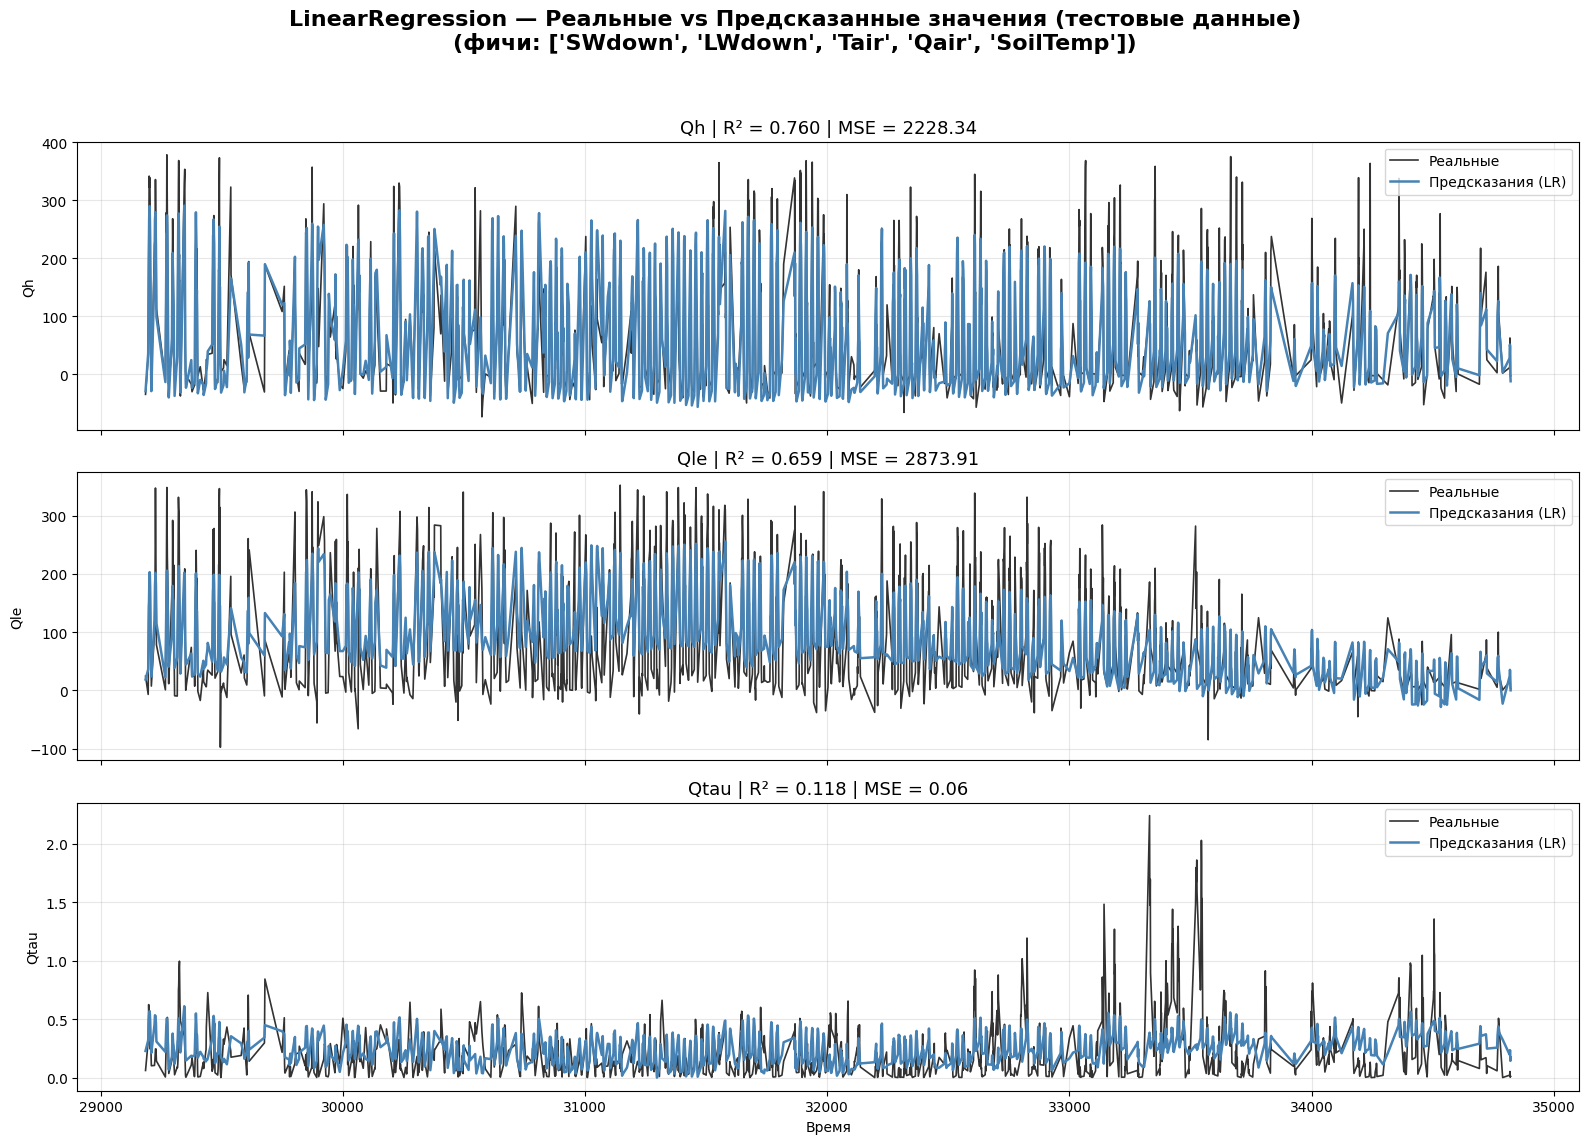

In [20]:
# === 1. График для LinearRegression (простые фичи) ===
fig_lr, axes_lr = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig_lr.suptitle('LinearRegression — Реальные vs Предсказанные значения (тестовые данные)\n'
                f'(фичи: {simple_predictors})', 
                fontsize=16, fontweight='bold', y=0.98)

for idx, target in enumerate(targets):
    if target not in models_lr:
        continue
    
    # Данные только для текущей цели
    df_target = df_clean.dropna(subset=[target])
    y = df_target[target]
    X_simple = df_target[simple_predictors]
    
    # Разделение (точно такое же, как при обучении)
    _, X_test, _, y_test = train_test_split(
        X_simple, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Предсказания уже обученной модели
    y_pred = models_lr[target].predict(X_test)
    
    # Временная ось — индекс тестовых данных (это datetime из оригинального df)
    times = X_test.index

    ax = axes_lr[idx]
    ax.plot(times, y_test.values, label='Реальные', color='black', linewidth=1.2, alpha=0.8)
    ax.plot(times, y_pred, label='Предсказания (LR)', color='steelblue', linewidth=1.8)
    
    r2 = results_lr[target]['R2']
    mse = results_lr[target]['MSE']
    ax.set_title(f'{target} | R² = {r2:.3f} | MSE = {mse:.2f}', fontsize=13)
    ax.set_ylabel(target)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes_lr[-1].set_xlabel('Время')
fig_lr.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

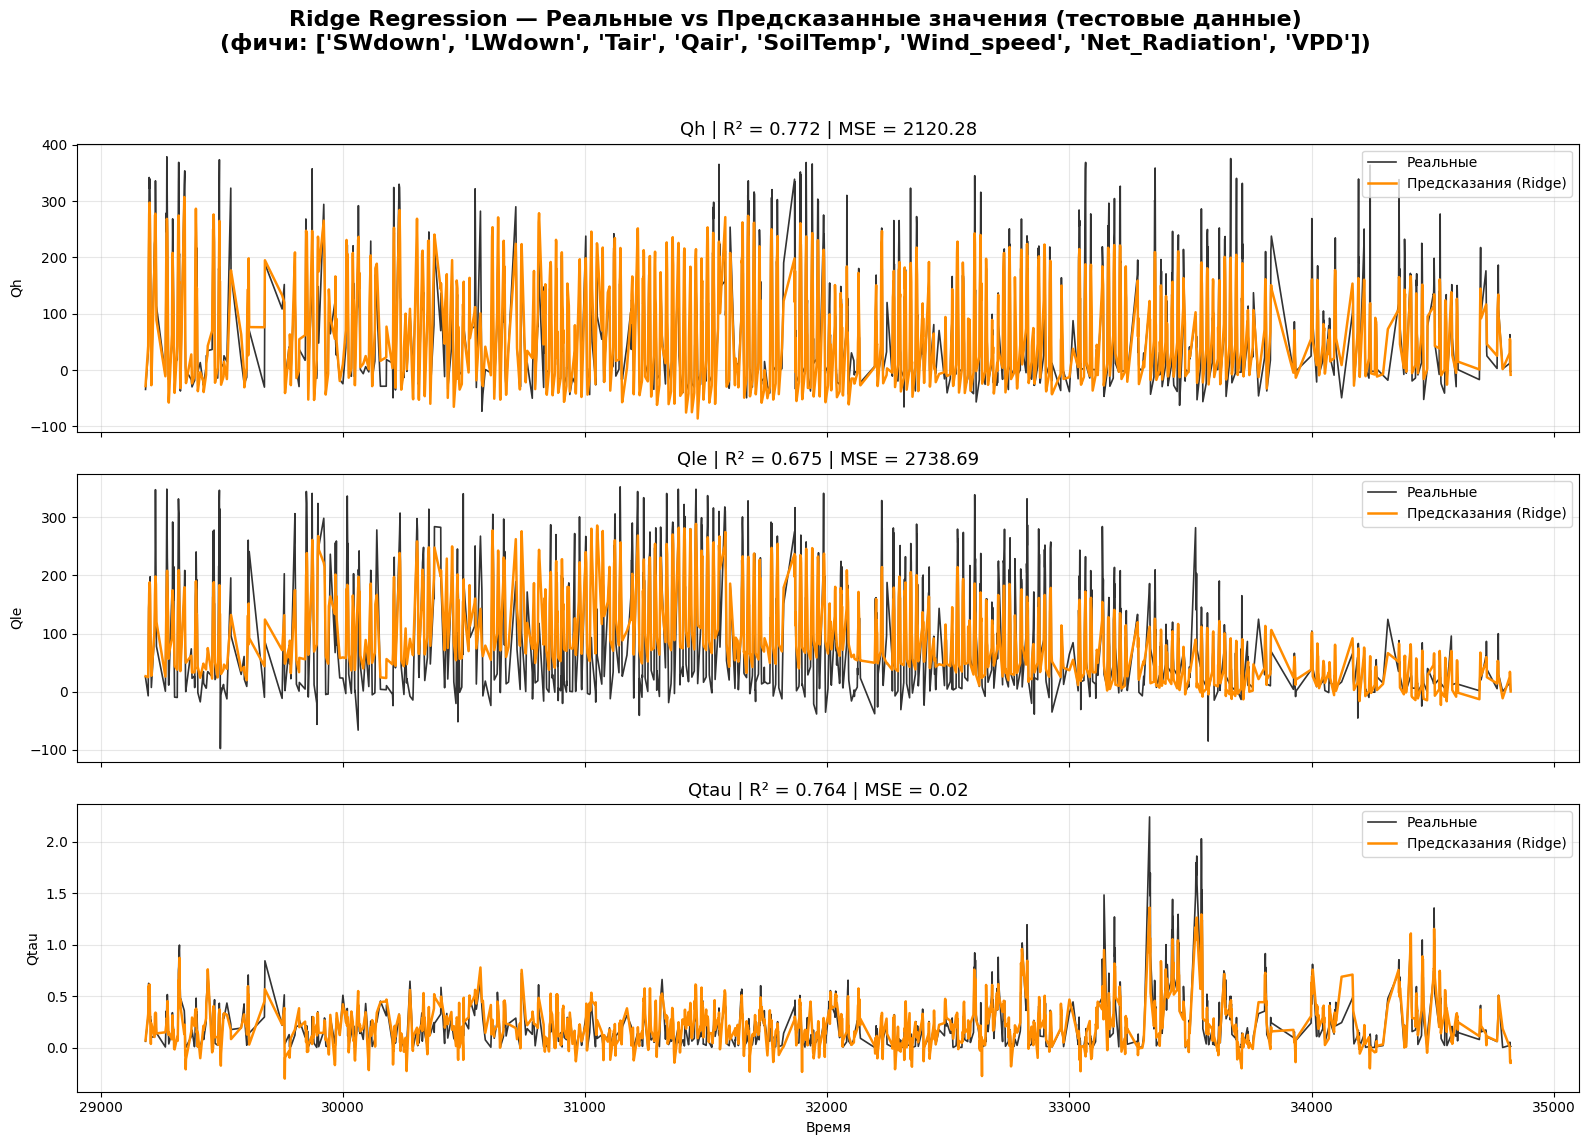

In [21]:
# === 2. График для Ridge
fig_ridge, axes_ridge = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig_ridge.suptitle('Ridge Regression — Реальные vs Предсказанные значения (тестовые данные)\n'
                   f'(фичи: {full_predictors})', 
                   fontsize=16, fontweight='bold', y=0.98)

for idx, target in enumerate(targets):
    if target not in models_ridge:
        continue
    
    df_target = df_clean.dropna(subset=[target])
    y = df_target[target]
    X_full = df_target[full_predictors]
    
    _, X_test, _, y_test = train_test_split(
        X_full, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    y_pred = models_ridge[target].predict(X_test)
    times = X_test.index

    ax = axes_ridge[idx]
    ax.plot(times, y_test.values, label='Реальные', color='black', linewidth=1.2, alpha=0.8)
    ax.plot(times, y_pred, label='Предсказания (Ridge)', color='darkorange', linewidth=1.8)
    
    r2 = results_ridge[target]['R2']
    mse = results_ridge[target]['MSE']
    ax.set_title(f'{target} | R² = {r2:.3f} | MSE = {mse:.2f}', fontsize=13)
    ax.set_ylabel(target)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes_ridge[-1].set_xlabel('Время')
fig_ridge.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [22]:

def evaluate_model_quality_from_models(models_dict, predictors_list, model_name="Модель"):
    """
    Оценивает качество сохранённых моделей напрямую (без готовых results_dict).
    models_dict — словарь с моделями: {'Qh': model, 'Qle': model, ...}
    predictors_list — список предикторов, использованных для этой модели
    """
    print(f"\n{'='*70}")
    print(f"ОЦЕНКА КАЧЕСТВА: {model_name}")
    print(f"{'='*70}")
    
    for target in targets:
        if target not in models_dict:
            print(f"{target}: модель не найдена")
            continue
        
        model = models_dict[target]
        
        # Данные только где есть цель
        df_target = df_clean.dropna(subset=[target])
        if len(df_target) < 100:
            print(f"{target}: недостаточно данных ({len(df_target)} строк)")
            continue
        
        X = df_target[predictors_list]
        y = df_target[target]
        
        # Делаем то же разделение, что и при обучении (shuffle=False для временных рядов)
        _, X_test, _, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, shuffle=False
        )
        
        # Предсказания на тесте
        y_pred = model.predict(X_test)
        
        # Метрики
        r2   = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae  = mean_absolute_error(y_test, y_pred)
        bias = np.mean(y_pred - y_test)
        
        print(f"\n{target}:")
        print(f"  R²   = {r2:.3f}")
        print(f"  RMSE = {rmse:.2f} " + ("Вт/м²" if target != 'Qtau' else "(ед. Qtau)"))
        print(f"  MAE  = {mae:.2f} Вт/м²")
        print(f"  Bias = {bias:+.2f} Вт/м²")
        
        # === Оценка по порогам ===
        if target == 'Qh':
            if r2 > 0.85 and rmse < 50:
                quality = "ОТЛИЧНАЯ модель (радиация очень хорошо объясняет Qh)"
            elif r2 > 0.75 and rmse < 70:
                quality = "ХОРОШАЯ модель"
            elif r2 > 0.60:
                quality = "СРЕДНЯЯ (есть запас для улучшения)"
            else:
                quality = "СЛАБАЯ — стоит попробовать нелинейные модели"
                
        elif target == 'Qle':
            if r2 > 0.70 and rmse < 60:
                quality = "ОТЛИЧНАЯ для городского сайта! (Qle сложно предсказывать)"
            elif r2 > 0.60 and rmse < 80:
                quality = "ХОРОШАЯ модель"
            elif r2 > 0.40:
                quality = "СРЕДНЯЯ (типично для urban flux tower)"
            else:
                quality = "СЛАБАЯ — добавьте больше признаков влажности/сезонности"
                
        elif target == 'Qtau':
            if r2 > 0.70 and rmse < 0.20:
                quality = "ОТЛИЧНАЯ модель"
            elif r2 > 0.60 and rmse < 0.30:
                quality = "ХОРОШАЯ модель"
            elif r2 > 0.50:
                quality = "СРЕДНЯЯ"
            else:
                quality = "СЛАБАЯ — возможно, нужны lagged ветровые признаки"
        
        print(f"  → ОЦЕНКА: {quality}")

# === Использование после обучения (когда модели уже сохранены в models_lr и models_ridge) ===

# Для LinearRegression (использовал simple_predictors)
evaluate_model_quality_from_models(
    models_dict = models_lr,
    predictors_list = simple_predictors,
    model_name = "LinearRegression (простые фичи: SWdown, LWdown, Tair, Qair, SoilTemp)"
)

# Для Ridge (использовал full_predictors)
evaluate_model_quality_from_models(
    models_dict = models_ridge,
    predictors_list = full_predictors,
    model_name = "Ridge (улучшенные фичи: Net_Radiation, VPD, Wind_speed и др.)"
)


ОЦЕНКА КАЧЕСТВА: LinearRegression (простые фичи: SWdown, LWdown, Tair, Qair, SoilTemp)

Qh:
  R²   = 0.760
  RMSE = 47.21 Вт/м²
  MAE  = 34.56 Вт/м²
  Bias = +0.70 Вт/м²
  → ОЦЕНКА: ХОРОШАЯ модель

Qle:
  R²   = 0.659
  RMSE = 53.61 Вт/м²
  MAE  = 41.71 Вт/м²
  Bias = +3.44 Вт/м²
  → ОЦЕНКА: ХОРОШАЯ модель

Qtau:
  R²   = 0.118
  RMSE = 0.25 (ед. Qtau)
  MAE  = 0.18 Вт/м²
  Bias = +0.03 Вт/м²
  → ОЦЕНКА: СЛАБАЯ — возможно, нужны lagged ветровые признаки

ОЦЕНКА КАЧЕСТВА: Ridge (улучшенные фичи: Net_Radiation, VPD, Wind_speed и др.)

Qh:
  R²   = 0.772
  RMSE = 46.05 Вт/м²
  MAE  = 34.11 Вт/м²
  Bias = +0.86 Вт/м²
  → ОЦЕНКА: ХОРОШАЯ модель

Qle:
  R²   = 0.675
  RMSE = 52.33 Вт/м²
  MAE  = 39.88 Вт/м²
  Bias = +3.69 Вт/м²
  → ОЦЕНКА: ХОРОШАЯ модель

Qtau:
  R²   = 0.764
  RMSE = 0.13 (ед. Qtau)
  MAE  = 0.09 Вт/м²
  Bias = -0.01 Вт/м²
  → ОЦЕНКА: ОТЛИЧНАЯ модель


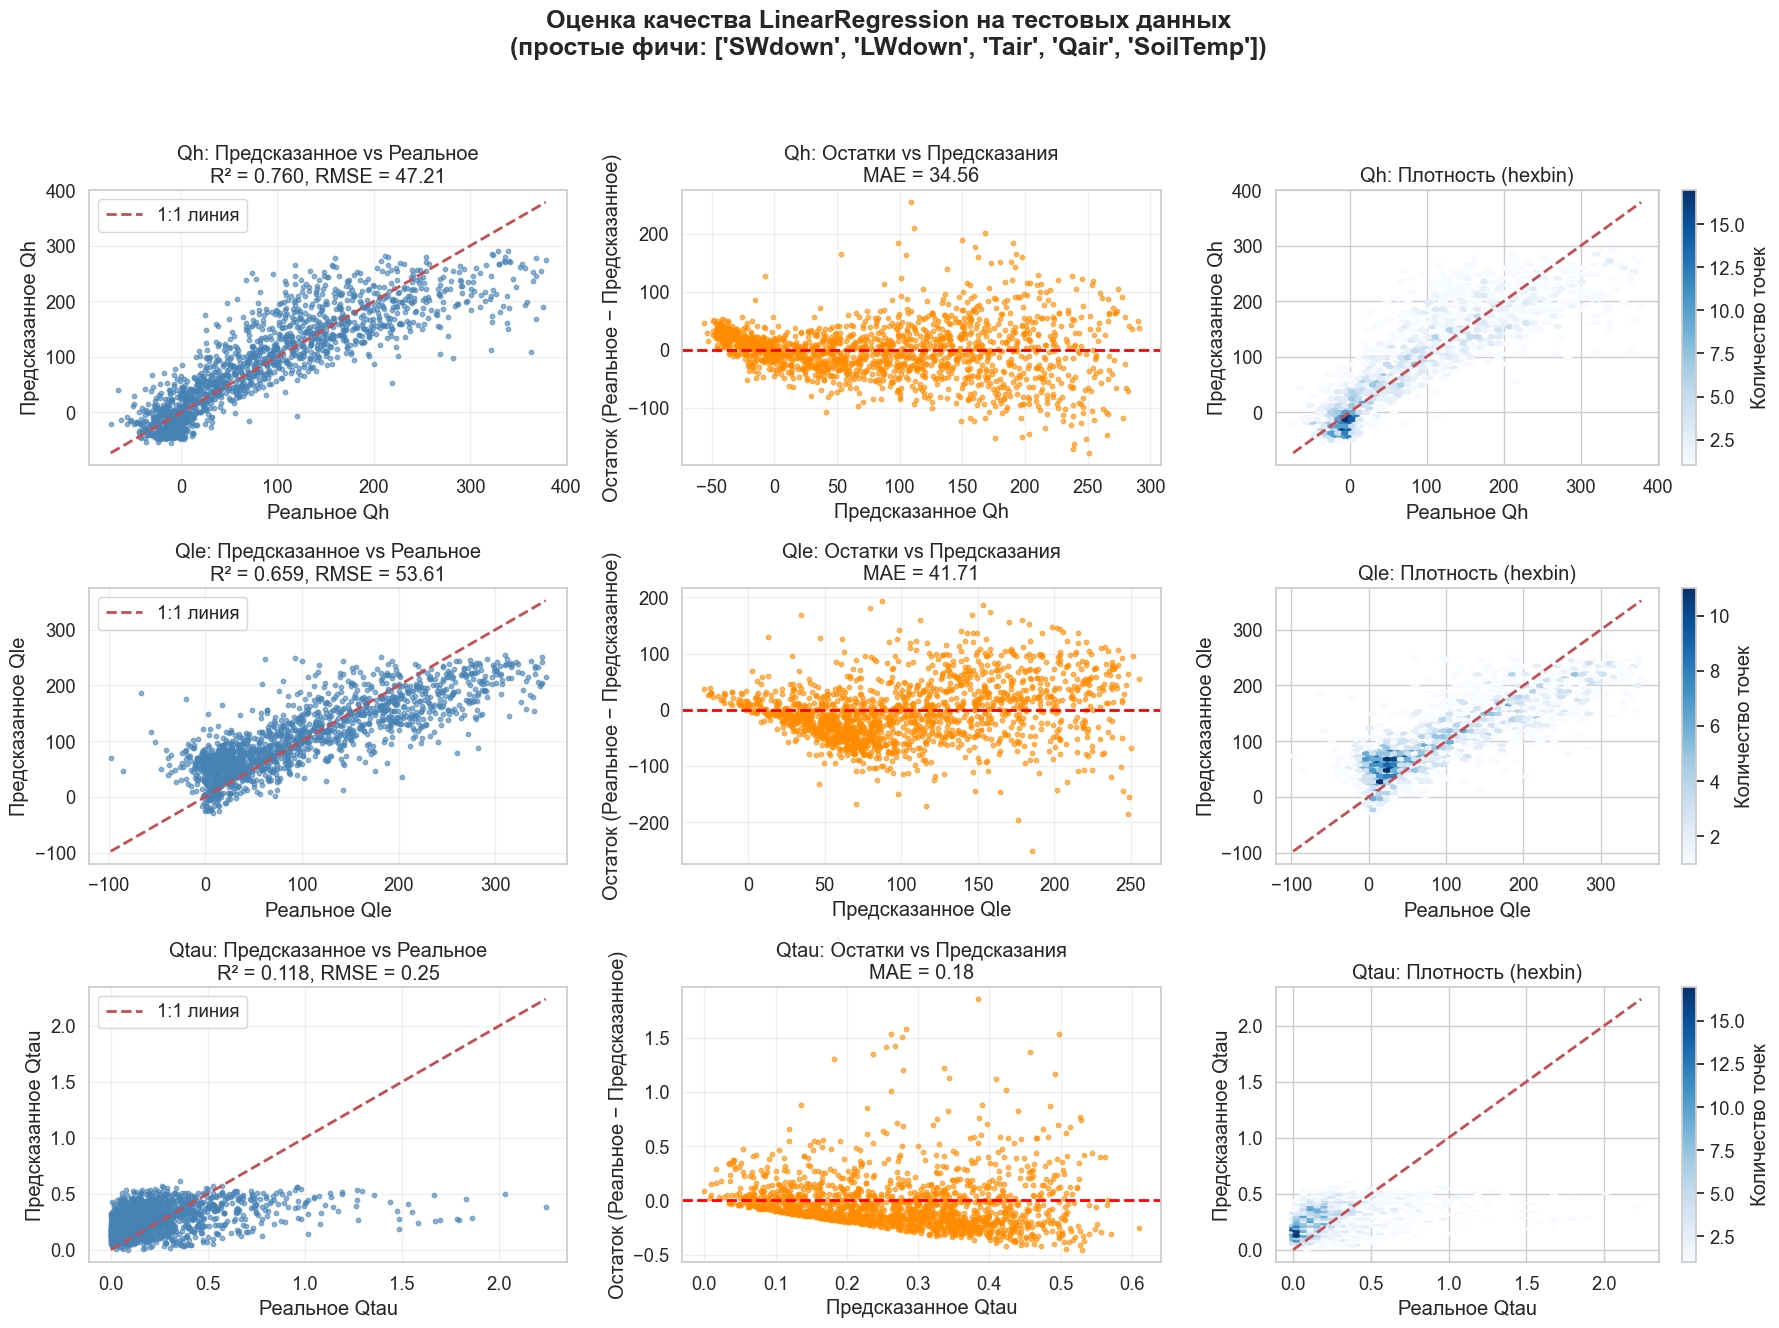

In [24]:
# Настройки
sns.set(style="whitegrid", font_scale=1.2)
fig = plt.figure(figsize=(18, 14))

for idx, target in enumerate(targets):
    if target not in models_lr:
        print(f"Модель LinearRegression для {target} не найдена")
        continue
    
    # Данные для цели
    df_target = df_clean.dropna(subset=[target])
    X = df_target[simple_predictors]  # простые фичи для LinearRegression
    y = df_target[target]
    
    # То же разделение, что и при обучении
    _, X_test, _, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Предсказания
    y_pred = models_lr[target].predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # === 1. Scatter plot: Предсказанное vs Реальное ===
    ax1 = plt.subplot(3, 3, idx*3 + 1)
    plt.scatter(y_test, y_pred, alpha=0.6, s=10, color='steelblue')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 линия')
    plt.xlabel(f"Реальное {target}")
    plt.ylabel(f"Предсказанное {target}")
    plt.title(f"{target}: Предсказанное vs Реальное\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # === 2. Residuals vs Predicted ===
    residuals = y_test.values - y_pred
    ax2 = plt.subplot(3, 3, idx*3 + 2)
    plt.scatter(y_pred, residuals, alpha=0.6, s=10, color='darkorange')
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel(f"Предсказанное {target}")
    plt.ylabel("Остаток (Реальное − Предсказанное)")
    plt.title(f"{target}: Остатки vs Предсказания\nMAE = {mae:.2f}")
    plt.grid(True, alpha=0.3)
    
    # === 3. Hexbin: Плотность ===
    ax3 = plt.subplot(3, 3, idx*3 + 3)
    hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='Blues', mincnt=1)
    plt.colorbar(hb, label='Количество точек')
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel(f"Реальное {target}")
    plt.ylabel(f"Предсказанное {target}")
    plt.title(f"{target}: Плотность (hexbin)")

plt.suptitle("Оценка качества LinearRegression на тестовых данных\n"
             f"(простые фичи: {simple_predictors})", 
             fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

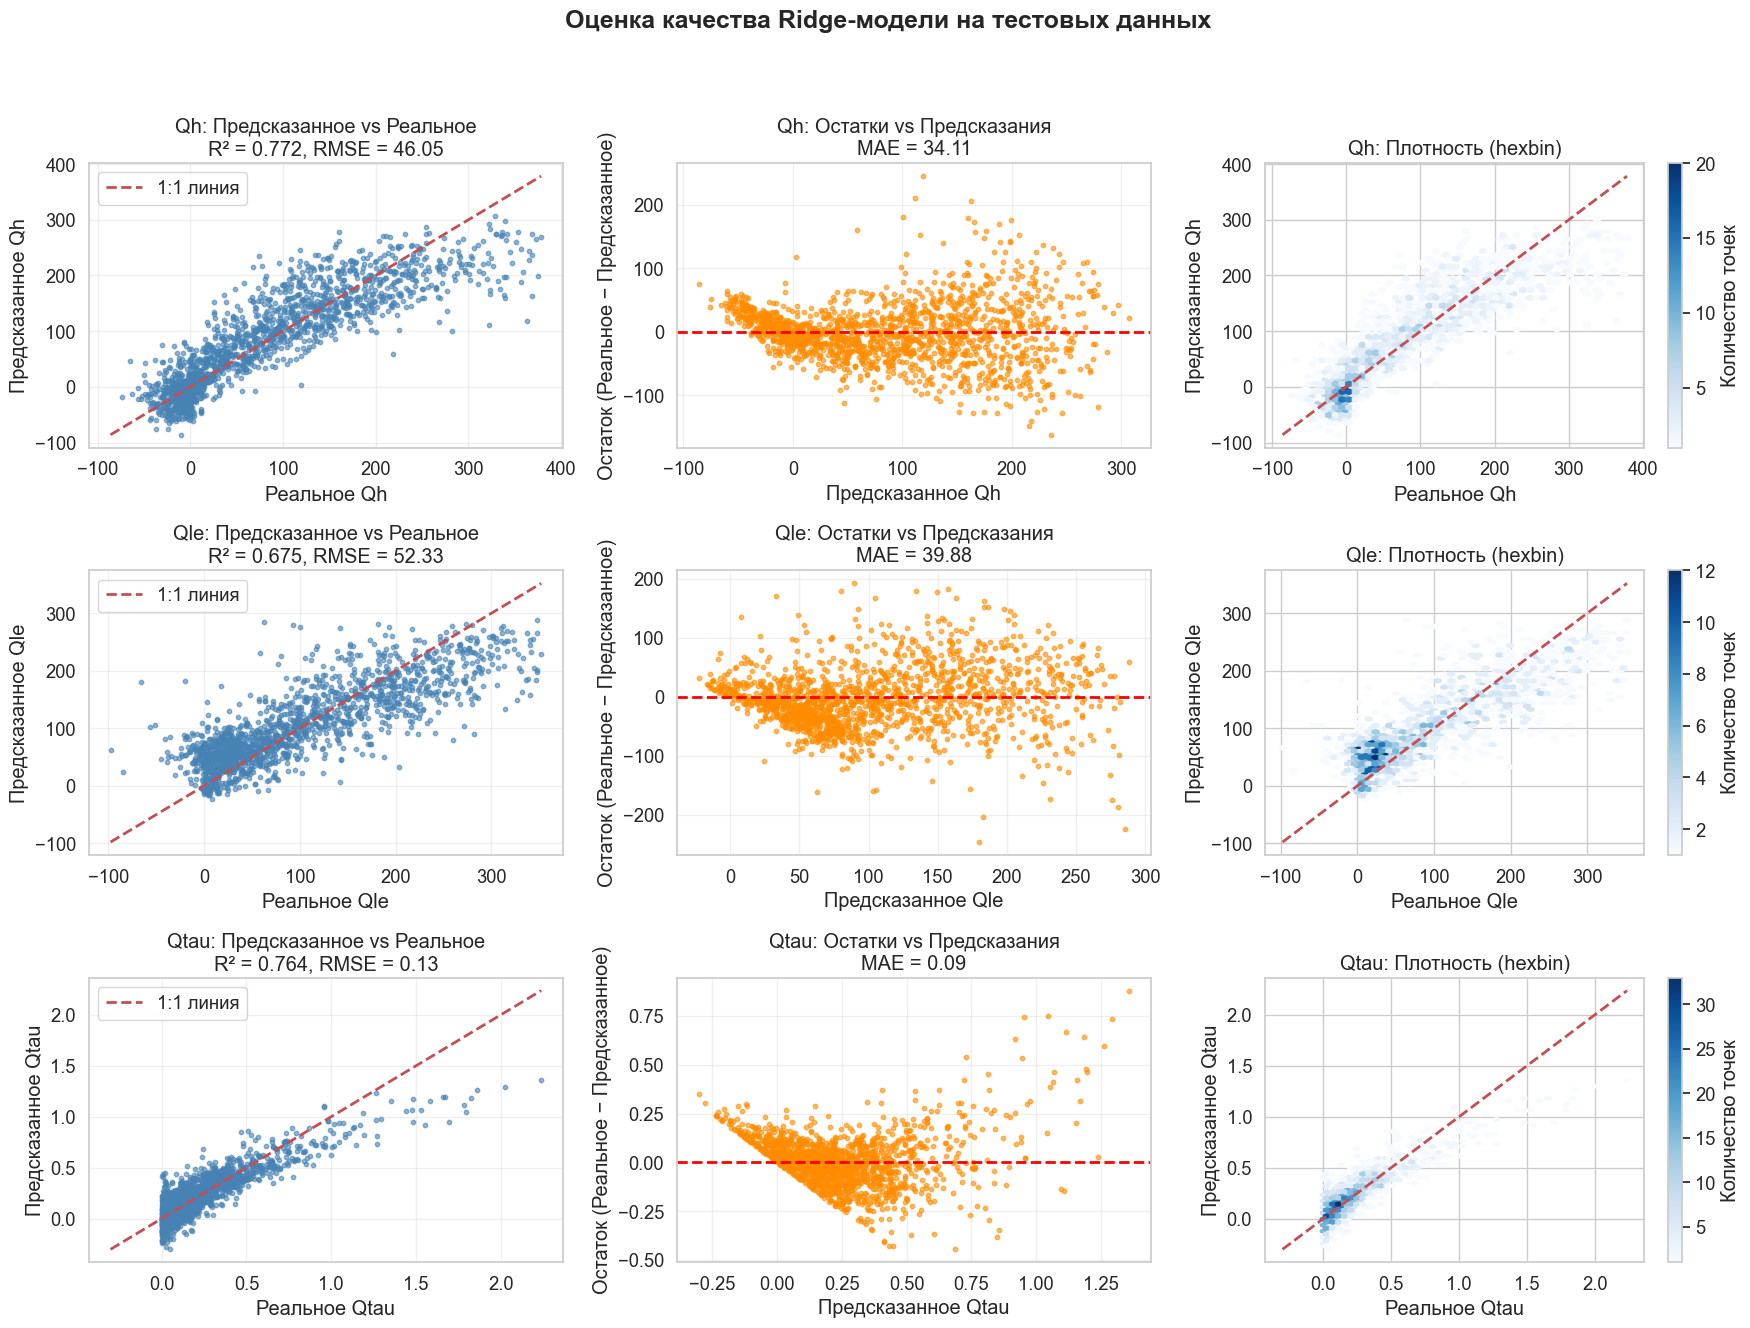

In [23]:
# Настройки для красивых графиков
sns.set(style="whitegrid", font_scale=1.2)
fig = plt.figure(figsize=(18, 14))

# Списки для хранения тестовых данных и предсказаний
test_data = {}
predictions = {}

for idx, target in enumerate(targets):
    if target not in models_ridge:
        continue
    
    df_target = df_clean.dropna(subset=[target])
    X = df_target[full_predictors]
    y = df_target[target]
    
    # То же разделение, что и при обучении
    _, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    y_pred = models_ridge[target].predict(X_test)
    
    # Сохраняем для графиков
    test_data[target] = y_test.values
    predictions[target] = y_pred
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    
    # === 1. Scatter plot ===
    ax1 = plt.subplot(3, 3, idx*3 + 1)
    plt.scatter(y_test, y_pred, alpha=0.6, s=10, color='steelblue')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='1:1 линия')
    plt.xlabel(f"Реальное {target}")
    plt.ylabel(f"Предсказанное {target}")
    plt.title(f"{target}: Предсказанное vs Реальное\nR² = {r2:.3f}, RMSE = {rmse:.2f}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # === 2. Residuals vs Predicted ===
    residuals = y_test.values - y_pred
    ax2 = plt.subplot(3, 3, idx*3 + 2)
    plt.scatter(y_pred, residuals, alpha=0.6, s=10, color='darkorange')
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.xlabel(f"Предсказанное {target}")
    plt.ylabel("Остаток (Реальное − Предсказанное)")
    plt.title(f"{target}: Остатки vs Предсказания\nMAE = {mae:.2f}")
    plt.grid(True, alpha=0.3)
    
    # === 3. Density scatter (hexbin) ===
    ax3 = plt.subplot(3, 3, idx*3 + 3)
    hb = plt.hexbin(y_test, y_pred, gridsize=50, cmap='Blues', mincnt=1)
    plt.colorbar(hb, label='Количество точек')
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    plt.xlabel(f"Реальное {target}")
    plt.ylabel(f"Предсказанное {target}")
    plt.title(f"{target}: Плотность (hexbin)")

plt.suptitle("Оценка качества Ridge-модели на тестовых данных", fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Запуск обучения Random Forest...

Обучение Random Forest для QH...
  → Qh: R² = 0.787 | RMSE = 44.48 | MAE = 31.09 | Bias = +0.70
Обучение Random Forest для QLE...
  → Qle: R² = 0.717 | RMSE = 48.84 | MAE = 34.85 | Bias = +4.49
Обучение Random Forest для QTAU...
  → Qtau: R² = 0.850 | RMSE = 0.10 | MAE = 0.07 | Bias = -0.00

Обучение Random Forest завершено!


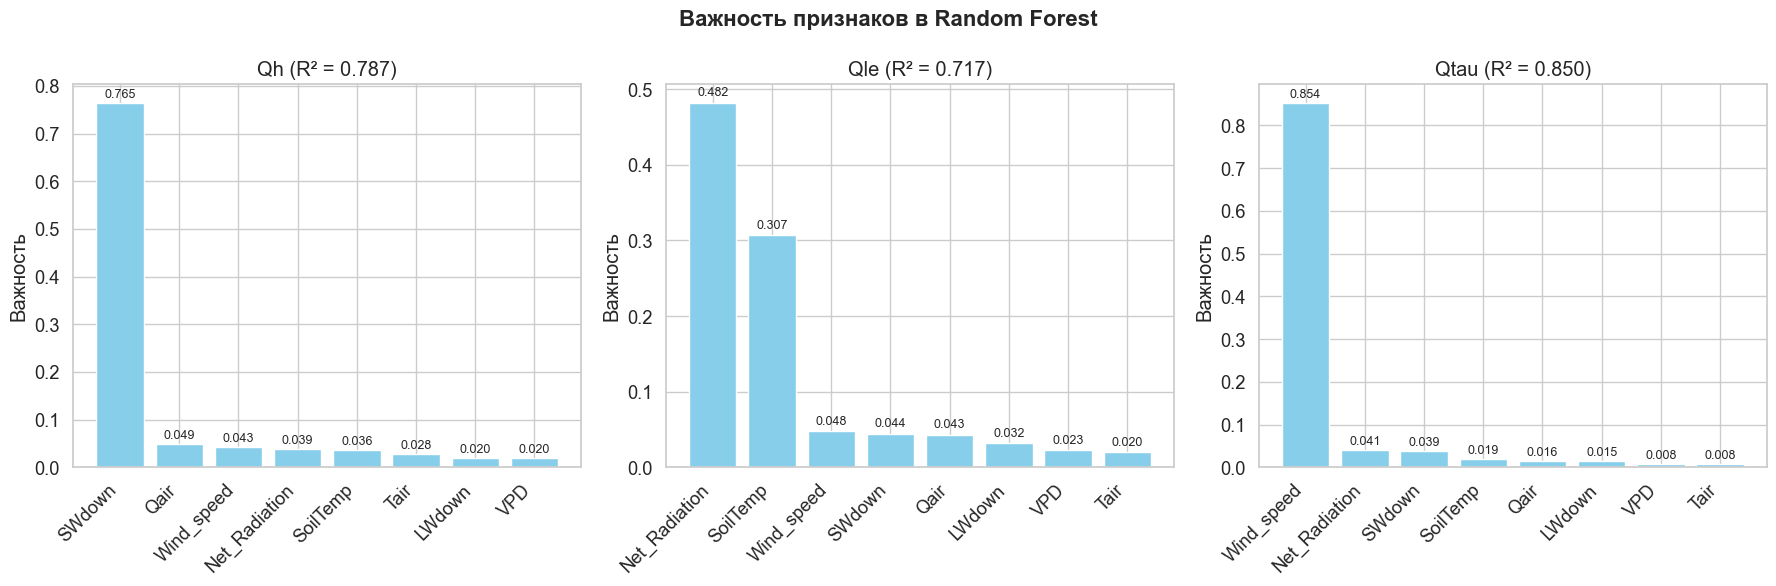

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Словари для хранения моделей и результатов
models_rf = {}
results_rf = {}

print("Запуск обучения Random Forest...\n")

for target in targets:
    print(f"Обучение Random Forest для {target.upper()}...")
    
    # Данные только где есть цель
    df_target = df_clean.dropna(subset=[target])
    if len(df_target) < 100:
        print(f"  → Недостаточно данных для {target}")
        continue
    
    X = df_target[full_predictors]
    y = df_target[target]
    
    # Разделение (то же, что и раньше: без shuffle для временных рядов)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Модель Random Forest
    model_rf = RandomForestRegressor(
        n_estimators=300,        # количество деревьев — можно 200–500
        max_depth=None,          # без ограничения глубины (или попробуйте 20–30)
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1                # использовать все ядра CPU
    )
    
    model_rf.fit(X_train, y_train)
    models_rf[target] = model_rf
    
    # Предсказания
    y_pred = model_rf.predict(X_test)
    
    # Метрики
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    bias = np.mean(y_pred - y_test)
    
    results_rf[target] = {
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Bias': bias
    }
    
    print(f"  → {target}: R² = {r2:.3f} | RMSE = {rmse:.2f} | MAE = {mae:.2f} | Bias = {bias:+.2f}")

print("\nОбучение Random Forest завершено!")

# === Вывод важности признаков для каждой цели ===
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Важность признаков в Random Forest", fontsize=16, fontweight='bold')

for idx, target in enumerate(targets):
    if target not in models_rf:
        continue
    
    model = models_rf[target]
    importances = model.feature_importances_
    
    # Сортируем по важности
    indices = np.argsort(importances)[::-1]
    
    ax = axes[idx]
    bars = ax.bar(range(len(full_predictors)), importances[indices], color='skyblue')
    ax.set_title(f"{target} (R² = {results_rf[target]['R2']:.3f})")
    ax.set_ylabel("Важность")
    ax.set_xticks(range(len(full_predictors)))
    ax.set_xticklabels([full_predictors[i] for i in indices], rotation=45, ha='right')
    
    # Подписываем значения над столбцами
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

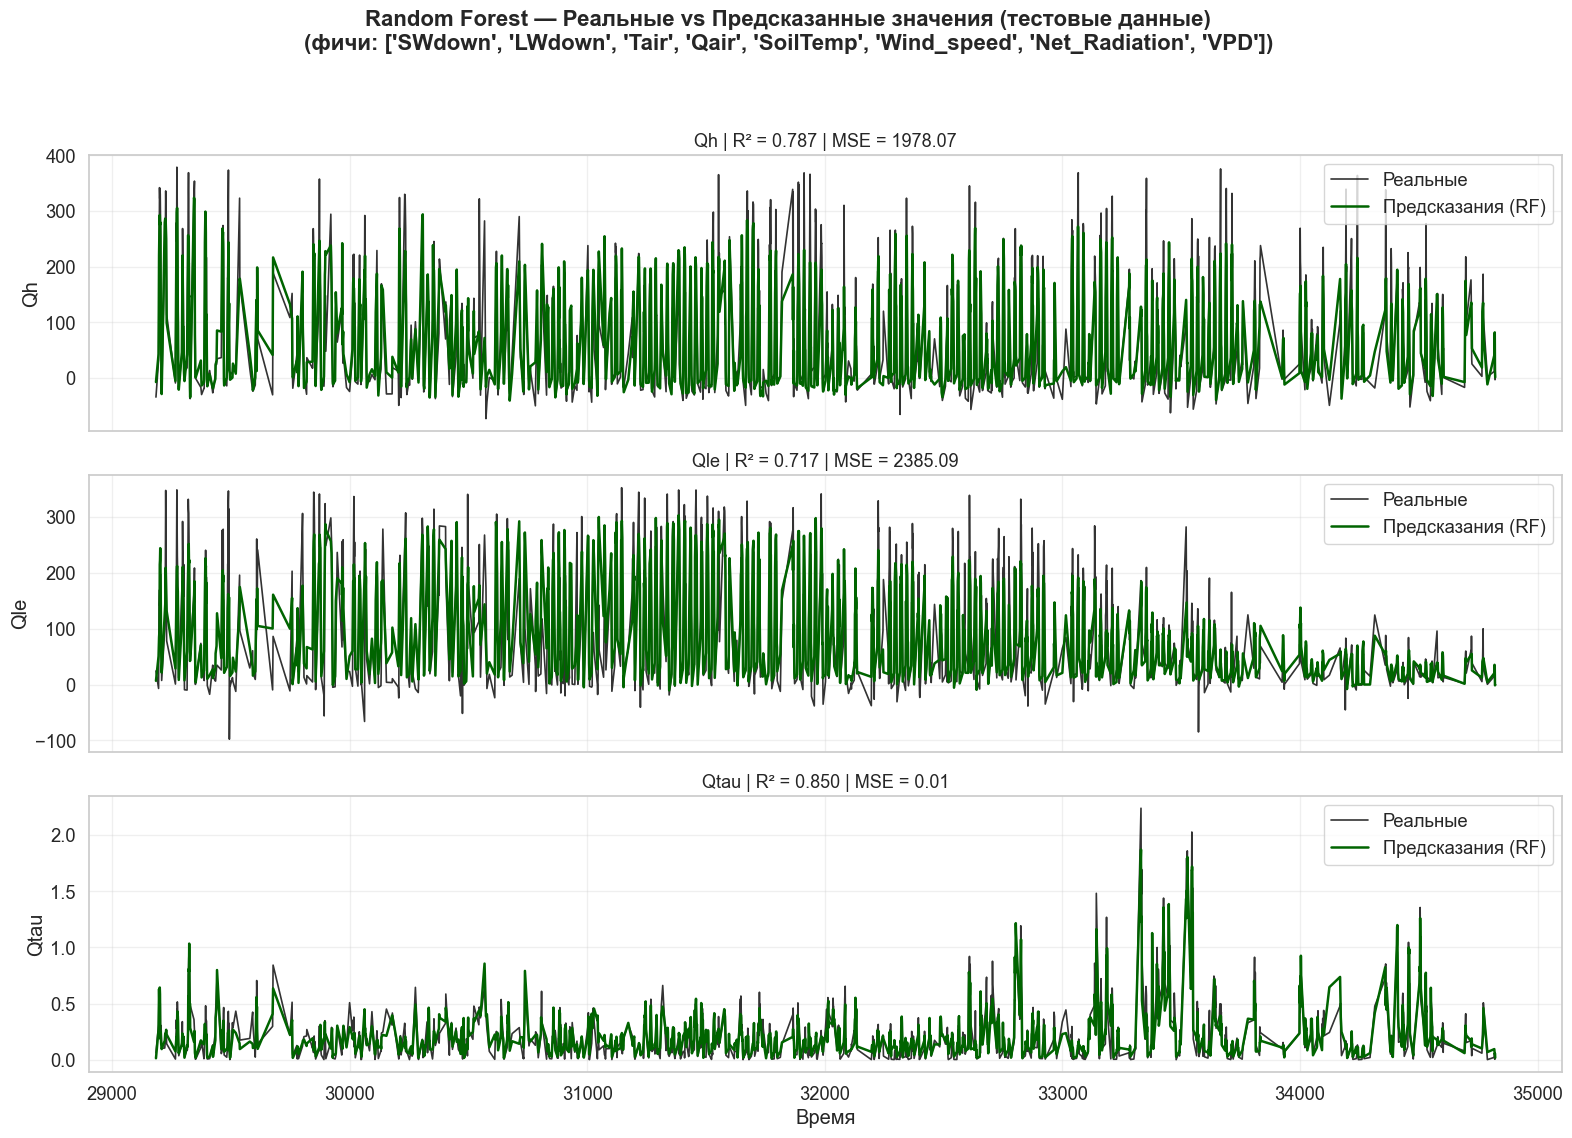

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Большой график с тремя панелями (Qh, Qle, Qtau)
fig, axes = plt.subplots(3, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Random Forest — Реальные vs Предсказанные значения (тестовые данные)\n'
             f'(фичи: {full_predictors})', 
             fontsize=16, fontweight='bold', y=0.98)

for idx, target in enumerate(targets):
    if target not in models_rf:
        print(f"Модель Random Forest для {target} не найдена")
        continue
    
    # Данные для цели
    df_target = df_clean.dropna(subset=[target])
    X = df_target[full_predictors]
    y = df_target[target]
    
    # То же разделение, что и при обучении
    _, X_test, _, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )
    
    # Предсказания Random Forest
    y_pred = models_rf[target].predict(X_test)
    
    # Расчёт метрик для заголовка
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Временная ось
    times = X_test.index
    
    ax = axes[idx]
    ax.plot(times, y_test.values, label='Реальные', color='black', linewidth=1.2, alpha=0.8)
    ax.plot(times, y_pred, label='Предсказания (RF)', color='darkgreen', linewidth=1.8)
    
    ax.set_title(f'{target} | R² = {r2:.3f} | MSE = {mse:.2f}', fontsize=13)
    ax.set_ylabel(target)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Время')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()